# MNIST Handwritten Digit Classification

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of the 10 possible classes representing integer values from 0 to 9 inclusively.

It is a widely used and deeply understood dataset and mostly “solved.” Top-performing models are deep learning convolutional neural networks that achieve a classification accuracy of above 99% with an error rate between 0.4 %and 0.2% on the hold out test dataset.

In [1]:
# Load standard libraries

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,skmultilearn -g

import os
import sys
import re
import yaml
import dateutil
import watermark
from tqdm import tqdm
from math import floor
from pprint import pprint as pp
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas.plotting import register_matplotlib_converters    # for pandas_profiling

register_matplotlib_converters()                              # for pandas_profiling

CPython 3.7.3
IPython 7.8.0

numpy 1.16.4
pandas 0.25.0
skmultilearn not installed

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : 3691fc4c659a85976ac343a5349964e06ecc8a71


### Load the data

We load it from the Keras library as well as some useful functions to create a Sequential model in Keras:

In [2]:
from keras.datasets import mnist
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# Loading MINST dataset (Train and Test)
(tr_x, tr_y), (te_x, te_y) = mnist.load_data()

Using TensorFlow backend.


Train shape: 	(60000, 28, 28), (60000,)
Test shape: 	(10000, 28, 28), (10000,)


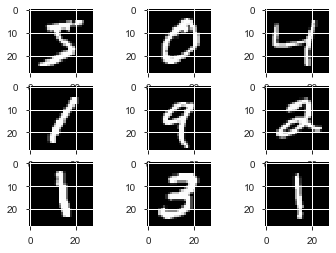

In [3]:
# summarize loaded dataset
print(f"Train shape: \t{tr_x.shape}, {tr_y.shape}")
print(f"Test shape: \t{te_x.shape}, {te_y.shape}")

# plotting first images
for i in range(9):
    plt.subplot(330 + 1 + i)                            # subplot def
    plt.imshow(tr_x[i], cmap=plt.get_cmap('gray'))   # raw pixel data
# plt.show()

In [4]:
print(f"Labels in tr_y: {tr_y[:9]}")

Labels in tr_y: [5 0 4 1 9 2 1 3 1]


We can see that there are 60,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 28×28 pixels. The format of the data for each entry is a list of lists.

In [5]:
tr_x[0].shape

(28, 28)

### Futher data preparation

Points to consider:

- The color of the numbers in this set are always white. We could invert the images so that we force the model to learn about the shape rather than searching purely white values.

- To feed the data into the deep learning model we must prepare the data as a 1-D vector. 

- Since the images are all pre-aligned (e.g. each image only contains a single hand-drawn digit), all have the same square size of 28×28 pixels and the images are grayscale, we can reshape the data arrays to have a single color channel.

In [6]:
# reshape dataset to have a single channel
tr_x = tr_x.reshape((tr_x.shape[0], 28, 28, 1))
te_x = te_x.reshape((te_x.shape[0], 28, 28, 1))

From the point of view of the output we know that there are 10 classes and these are represented as unique integers.

Therefore we can use a one hot encoding for the class element of each sample, transforming the integers into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes.

In [7]:
# one hot encode target values
tr_y_enc = to_categorical(tr_y)
te_y_enc = to_categorical(te_y)

tr_y_enc[:2]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

The pixel values for each image in the dataset are unsigned integers in the range between black and white (or 0 and 255).

We do not know the best way to scale the pixel values for modeling, but we know that some **scaling** will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [8]:
def normalize_pixels(v):
    v_norm = v.astype("float32")
    v_norm = v_norm / 255.0
    return v_norm

# convert from integers to floats
tr_x_norm = normalize_pixels(tr_x)
te_x_norm = normalize_pixels(te_x)

In [9]:
tr_x_norm[0][15].ravel()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1764706 ,
       0.7294118 , 0.99215686, 0.99215686, 0.5882353 , 0.10588235,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

If we pack all the steps together...

In [10]:
def convert_pixels(pix, mirror=False):
    # convert from integers to floats
    pix_norm = pix.astype('float32')
    # normalize to range 0-1
    pix_norm = pix_norm / 255.0
    if mirror:
        m = 1 - pix_norm
        pix_norm = np.concatenate((pix_norm, m), axis=0)
    return pix_norm

def pre_process(train, test, mirror=False):
    return convert_pixels(train, mirror=mirror), convert_pixels(test, mirror=False)

## Baseline Model

In ML is typical to start with an initial model in which we apply the metrics and evaluation that are adequate for that type of model and we will use that model as comparison for any future model while we try to improve on its accuracy. Our baseline is going to be a convolutional neural network model.

The model has two main aspects:
- The feature extraction front end comprised of convolutional and pooling layers.
- The classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single **convolutional layer**(\*1) with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a **softmax activation** (\*2) function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

#### Notes:
(\*1) **Convolutional Neural Networks** (CNNs) are based on the image processing of many animals and take leverage on the spatial information of the image, that is, nodes that are close together are important because they help to define the features of the image.  With this in mid, CNNs apply a filter that slide through the input and from each application we obtain a single value. For example in a 32x32 we could apply an 5x5 filter obtaining a 28x28 output after the convolution. [More](https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8).

<img src="./fig/convolution_01.png" alt="Convolution example" width="200"/>

(\*2) **Softmax activation** is a function with certain advantages over the sigmoid function.
- It's the probabilities of each target class over all possible classes.
- Output range from 0 to 1 (vs. sigmoid being in the range of -1 to 1)
- The sum of all probabilities equal to one, so in multi-classification the model returns the probability of each class so we just select the class with higher probability.

(\*3) An **Activation Function** is just a function that you use to get the output of a node. It is also known as Transfer Function. It maps the values between 0 to 1 or -1 to 1, etc (depending upon the function). There are two main classes:
1. Linear Activation Function (ex: linear function)
2. Non-linear Activation Functions (ex: ReLU)

<img src="./fig/Sigmoid_vs_ReLu.png" alt="Sigmoid vs. ReLU" width="500"/>

More [info](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

ReLU is linear (identity) for all positive values and zero for all negative values, so:
- It's cheap
- Converges fast
- It's sparsely activated. Being negative for all negative values, it's likely for any given unit to not activate at all. This is often desirable. (This is model sparsity which is different from data sparsity which is usually bad). This makes sense from the point of view of specialization, not all neurons work in a specific task since some neurons solve better than others a specific problem

#### Dead neurons

A neuron is “dead” if always outputs 0. For example in ReLu, because the slope in the negative range is also 0, once a neuron gets negative, it’s unlikely for it to recover. Such neurons are not playing any role discriminating the input and is essentially useless. Over the time you may end up with a large part of your network doing nothing.

A single step (ex: in SGD) involves multiple data points. As long as not all of them are negative, we can still get a slope out of ReLU. The dying problem is likely to occur when learning rate is too high or there is a large negative bias.

Lower learning rates often mitigates the problem. If not **leaky ReLU** and **ELU** are also good alternatives to try. They have a slight slope in the negative range, thereby preventing the issue.

#### Vanishing Gradient Problem

As more layers using certain activation functions are added to neural networks, the gradients of the loss function approaches zero making the network hard to train.

Certain activation functions like the sigmoid function, squishes a large input space into a small input space between 0 and 1. Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Hence, the derivative becomes small.

For shallow network with only a few layers that use these activations, this isn’t a big problem. However for more layers it can cause the gradient to be too small for training to work effectively.

Gradients of neural networks are found using backpropagation which in simple terms finds the derivatives of the network by moving layer by layer from the final layer to the initial one. By the chain rule the derivatives of each layer are multiplied down the network (from final to initial layer) to compute the derivatives of the initial layers.

However when n hidden layers use an activation like the sigmoid function, n small derivatives are multiplied together with the result of the gradient decreasing exponentially as we propagate down to the initial layers. Which means that the weights and biases of the initial layers will not be updated effectively with each training session. Since these initial layers are often crucial to recognizing the core elements of the input data, it can lead to overall inaccuracy of the whole network.

That's why we have other activation functions that don't cause a small derivative.

In [11]:
def define_cnn_model(filters=32, kernel=(3, 3), units=100):
    # The sequential API allows to create models layer-by-layer for most problems. It is limited in
    # that it does not allow you to create models that share layers or have multiple inputs or outputs.
    # For an alternate way of creating models with a lot more flexibility look into the functional API in Keras
    model = Sequential()
    # We can add as many layers as we want to the sequential model API
    # 1st layer in a Sequential model needs to receive information about its input shape
    model.add(Conv2D(filters=filters, kernel_size=kernel, 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     input_shape=(28, 28, 1)))
    # Max pooling is then used to reduce the spatial dimensions of the output volume.
    # It downsamples/summarizes the activation maps and keep the number of network parameters low.
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### Conv2D parameters
1. **number of filters**  that the convolutional layer will learn.
2. **kernel_size**, a 2-tuple specifying the width and height of the 2D convolution window.

##### *About the number of filters:*

Layers early in the network architecture (closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (closer to the output predictions) will learn more filters. Conv2D layers in between will learn more filters than the early Conv2D layers but fewer filters than the layers closer to the output.

After each convolution we add MaxPooling to reduce the spatial dimentions of the output.

Notice at as our output spatial volume is decreasing our number of filters learned is increasing (this is a common practice in designing CNN architectures). As far as choosing the appropriate number of filters, is recommended to almost always use powers of 2 as the values.

You may need to tune the exact value depending on (1) the **complexity** of your dataset and (2) the **depth** of your neural network, but I recommend starting with filters in the range [32, 64, 128] in the earlier and increase up to [256, 512, 1024] in the deeper layers.

Choose the range depending on the application but typically start with a small number of filters and only increase when necessary.<br>

#####  *About the kernel_size:*

The kernel_size  must be an **odd integer**. Typical values for kernel_size  include: (1, 1) , (3, 3) , (5, 5) , (7, 7) . It’s rare to see kernel sizes larger than 7×7.

How we choose?

If your input images are greater than 128×128 you may choose to use a kernel size > 3 to help (1) learn larger spatial filters and (2) to help reduce volume size.

Other networks such as VGGNet, exclusively use (3, 3)  filters throughout the entire network.

More advanced architectures such as Inception, ResNet, and SqueezeNet design entire micro-architectures which are “modules” inside the network that learn local features at different scales (i.e., 1×1, 3×3, and 5×5) and then combine the outputs.

A great example can be seen in the Inception module below (GoogLeNet CNN architecture uses micro-architecture modules inside the network that learn local featuers at different scales):


<img src="./fig/keras_conv2d_inception_module.png" alt="Inception Module" width="500"/>


<img src="./fig/convolution_cat_01.png" alt="Cat 01" width="600"/><img src="./fig/convolution_cat_03.png" alt="Cat 03" width="600"/>


### MaxPooling

<img src="./fig/MaxPooling_01.jpeg" alt="Max Pooling" width="500"/>


## Model Evaluation

After the model is defined we need to decide on the metric we will use and the type of evaluation.

To estimate the performance of a model for a given training run we can further split the training set into a train and validation dataset. Performance on the train and validation dataset over each run can then be plotted to provide learning curves and insight into how well a model is learning the problem.

The model will be evaluated using five-fold **cross-validation** (typical values are k=5 and k=10), k=5 will provide a baseline for both repeated evaluation and we try not to make it so large as to require a long running time. 
This will give some account of the models variance with both respect to differences in the training and test datasets and in terms of the stochastic nature of the learning algorithm. The performance of a model can be taken as the mean performance across k-folds, given the standard deviation, that could be used to estimate a confidence interval if desired. Each test set will be 20% of the training dataset, or about 12k examples, close to the size of the actual test set for this problem.

The training dataset is **shuffled** prior to being split and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

We wrap all this on an evaluation function that will retur a list of accuracy scores and training histories that can be later summarized.

In [12]:
# evaluate a model using k-fold cross-validation
def k_fold_evaluation(model, data_x, data_y, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=42)
    # enumerate splits
    for train_ix, test_ix in kfold.split(data_x):
        # select rows for train and test
        trainX, trainY, testX, testY = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print(f"Accuracy: {(acc * 100.0):.3f}")
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

## Result Graphs

There are two key aspects to present:
1. Diagnostics of the learning behavior of the model during training.
2. Estimation of the model performance.

The **diagnostics** involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We can incorporate on a single figure two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset.

In [18]:
def summarize_diagnostics(histories):
    fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(8,6))
    ax1, ax2, ax3, ax4 = axes.flatten()
    
    # We have 10 different classes in the history and we plot the Loss and Accuracy for all the classes.
    for i in range(len(histories)):
        # Plot loss
        ax1.set_title('Cross Entropy Loss [train]')
        ax1.plot(histories[i].history['loss'], color='blue', label='train')
        ax2.set_title('Cross Entropy Loss [test]')
        ax2.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # Plot accuracy
        ax3.set_title('Classification Accuracy [train]')
        ax3.plot(histories[i].history['acc'], color='blue', label='train')
        ax4.set_title('Classification Accuracy [test]')
        ax4.plot(histories[i].history['val_acc'], color='orange', label='test')

    plt.tight_layout();

For the model **performance** we can summarize the classification accuracy scores collected during each fold by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

In [14]:
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
#     fig, axes = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(5,5))
    plt.boxplot(scores)
    fig = plt.gcf()
    fig.set_size_inches(14, 6)

### Adding everything together

In [15]:
# load train and test dataset
def load_dataset():
    # Load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # One hot encoding of labels
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY


def run_test_harness():
    # Get data
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = pre_process(trainX, testX)
    # Define model
    model = define_cnn_model(filters=16, kernel=(3, 3), units=50)
    # Evaluate model
    scores, histories = k_fold_evaluation(model, trainX, trainY)
    
    return scores, histories

In [16]:
# evaluate model
scores1, histories1 = run_test_harness()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Accuracy: 98.442
Accuracy: 99.725
Accuracy: 99.992
Accuracy: 100.000
Accuracy: 100.000


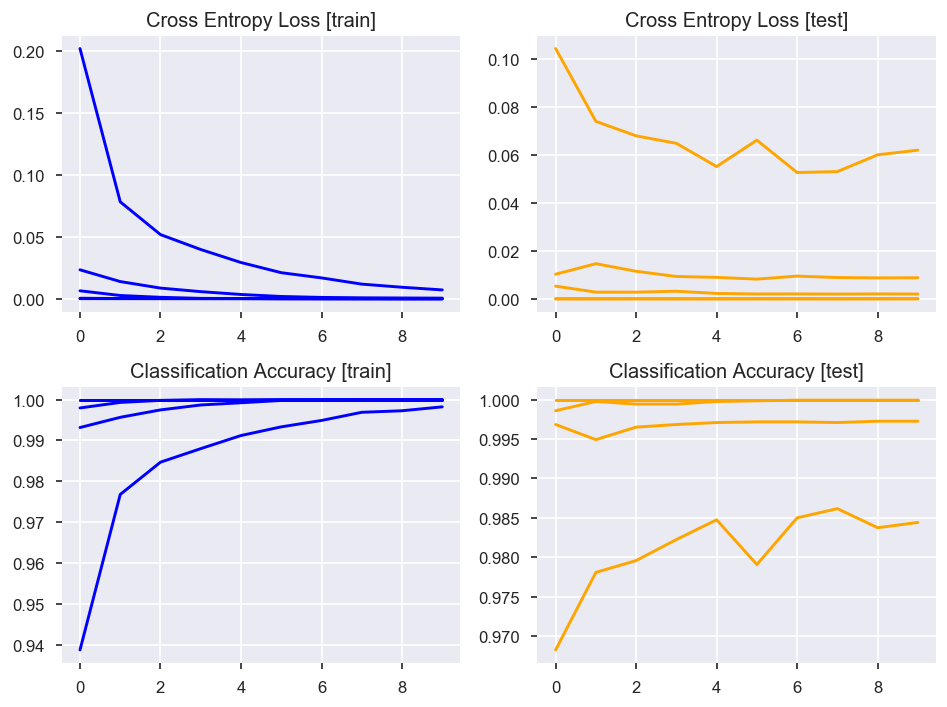

In [19]:
# learning curves
summarize_diagnostics(histories1)

Accuracy: mean=99.632 std=0.604, n=5


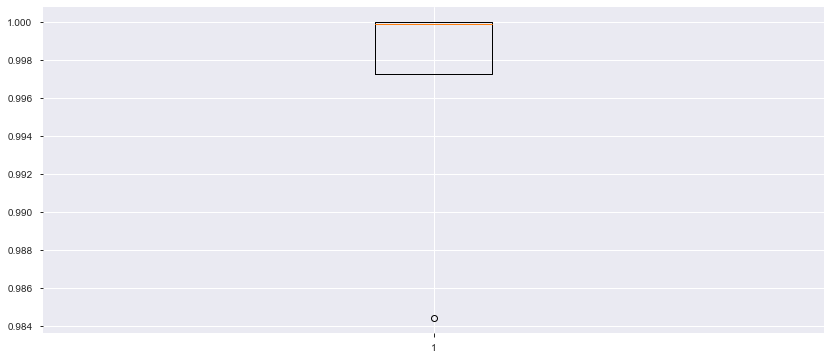

In [20]:
# summarize estimated performance
summarize_performance(scores1)

### Model improvement

In [21]:
# We add BatchNormalization
from keras.layers import BatchNormalization


def cnn_impr_model(filters=32, kernel=(3, 3), units=100):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel, 
                     activation='relu', 
                     kernel_initializer='he_uniform', 
                     input_shape=(28, 28, 1)))
    model.add(BatchNormalization())                     # Added Batch Normalization
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(units=units, 
                    activation='relu', 
                    kernel_initializer='he_uniform'))
    model.add(BatchNormalization())                     # Added Batch Normalization
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
def run_test_harness2():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = pre_process(trainX, testX)
    # define model
    model = cnn_impr_model(filters=16, kernel=(3, 3), units=50)
    # evaluate model
    scores, histories = k_fold_evaluation(model, trainX, trainY)
    
    return scores, histories

In [23]:
# evaluate model
scores2, histories2 = run_test_harness2()

Accuracy: 98.392
Accuracy: 99.658
Accuracy: 99.892
Accuracy: 99.983
Accuracy: 99.975


In [24]:
acc = 0.333333

In [25]:
print(f"Accuracy: {(acc * 100.0):.3f}")

Accuracy: 33.333


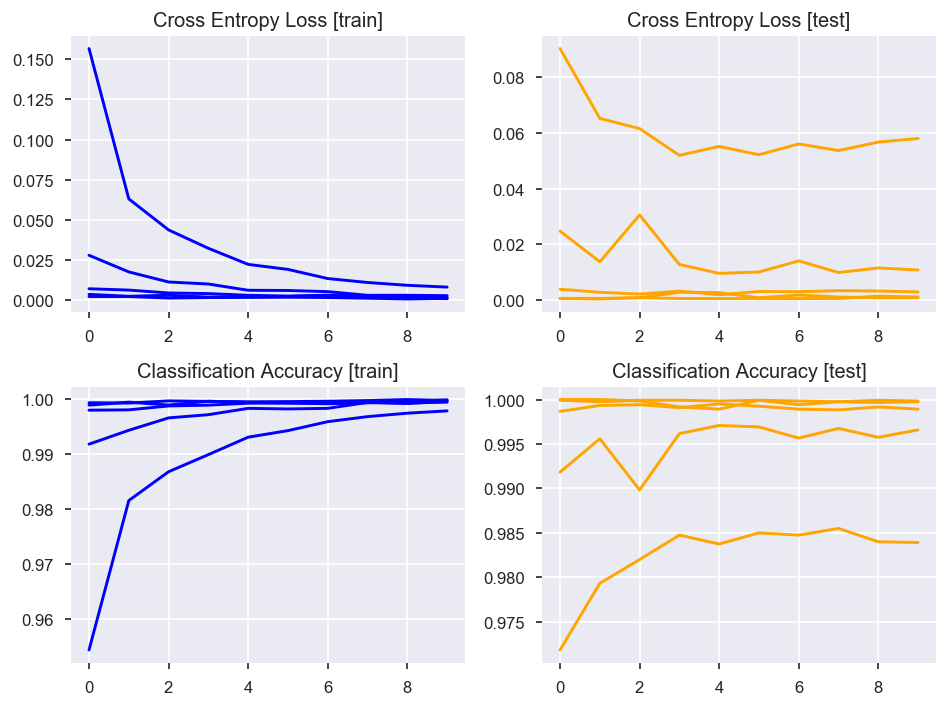

In [26]:
# learning curves
summarize_diagnostics(histories2)

Accuracy: mean=99.580 std=0.606, n=5


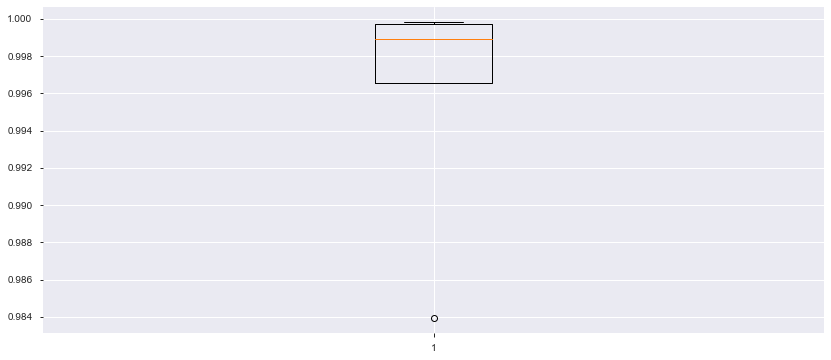

In [27]:
# summarize estimated performance
summarize_performance(scores2)

In [28]:
def run_test_harness3():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = pre_process(trainX, testX)
    # define model
    model = cnn_impr_model(filters=32, kernel=(3, 3), units=100)
    # evaluate model
    scores, histories = k_fold_evaluation(model, trainX, trainY)
    
    return scores, histories

In [29]:
### evaluate model
scores3, histories3 = run_test_harness3()

Accuracy: 98.658
Accuracy: 99.767
Accuracy: 99.967
Accuracy: 99.983
Accuracy: 99.983


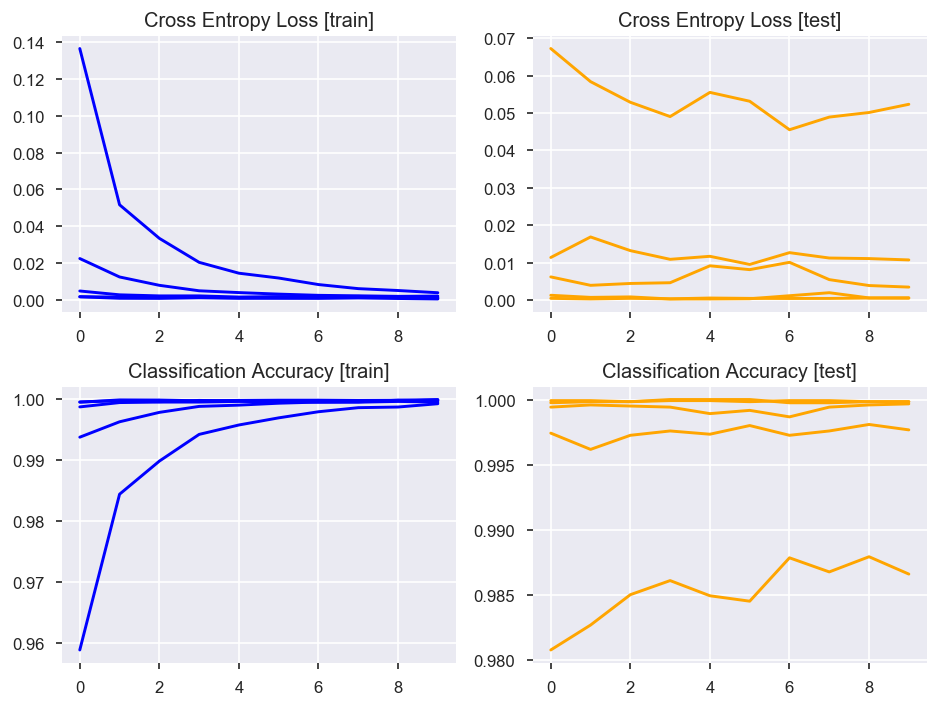

In [32]:
# learning curves
summarize_diagnostics(histories3)

Accuracy: mean=99.672 std=0.513, n=5


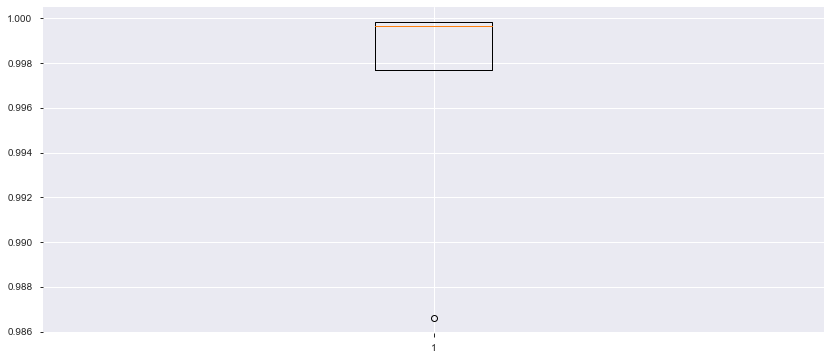

In [33]:
# summarize estimated performance
summarize_performance(scores3)